# LTV Classification

In [1]:
#Importing all Required  Libraries
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('IN')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',50)

In [2]:
import matplotlib.style as style # for styling the graphss
# style.available (to know the available list of styles)
style.use('ggplot') # chosen style
plt.rc('xtick',labelsize=13) # to globally set the tick size
plt.rc('ytick',labelsize=13) # to globally set the tick size
# To display float with 2 decimal, avoid scientific printing
pd.options.display.float_format = '{:.2f}'.format
import math
#Library for one hot encoding
from sklearn.preprocessing import OneHotEncoder
#train test split
from sklearn.model_selection import train_test_split
#Evaluation metrics
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score

In [3]:
invoice = pd.read_csv('cleaned_merged_data.csv')

In [4]:
    # invoice['year'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.year
# invoice['month'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.month
invoice["Invoice_DateTime"]=pd.to_datetime(invoice["Invoice_DateTime"],dayfirst=True)
invoice["JobCard_DateTime"]=pd.to_datetime(invoice["JobCard_DateTime"],dayfirst=True)
invoice['Service_Time'] = invoice['Invoice_DateTime'] - invoice['JobCard_DateTime']
# invoice['Service_Time_Hrs'] = invoice['Service_Time']/np.timedelta64(1,'h')
invoice['service_time_hours'].describe()

count   936275.00
mean        89.88
std        275.10
min         -0.01
25%          4.05
50%         23.26
75%         73.23
max      17769.26
Name: service_time_hours, dtype: float64

In [5]:
invoice[invoice['service_time_hours']<0]

,Unnamed: 0,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Total Amt Wtd Tax.,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Year,Month,Clean_CITY,Clean_District,Clean_Location_Area,latitude,longitude,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,Total_Expense,Total,car_age,km_bins,service_time_hours,service_time_days,labour_to_parts,ratio_bins,repair month
714423,714423,Retail,182085,00:00:00,7167000988,363294,62001,0.00,MARUTI,0.00,SWIFT DZIRE,0.00,Running Repairs,0.00,603103,X085,X085 - SRI MOTORS,NO,0.00,TN19M6594,0,X085SA1,2016-05-02 15:12:11,2016-05-02 15:12:44,-1 days +23:59:27,2016,5,Kanchipuram,Tamil Nadu,"Pudupakkam, Padur, Kelambakkam, Thaiyur",12.92,79.98,NaN,nan,NaN,363294.00,G2TX,0.00,0.00,0.00,0.00,6,50000 - 100000,-0.01,-0.00,0.00,Unprofitable,5


In [6]:
# dropping a row where service time is in negative
invoice.drop(index=714423,axis=0,inplace=True)

In [7]:
invoice_15=invoice[invoice["Year"]==2015]

In [8]:
# Calculating frequency of visits & total revenue of a customer for calculation of ltv

customer_freq=invoice_15.groupby(["Make","Model","Clean_Location_Area","Customer No."]).agg({"Invoice No":'nunique',"Total Amt Wtd Tax.":'mean',"service_time_hours":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head()

ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r["Invoice No"] * ltv_make_model_r["Total Amt Wtd Tax."]
ltv_make_model_r.head()

,Make,Model,Clean_Location_Area,Customer No.,Invoice No,Total Amt Wtd Tax.,service_time_hours,LTV
0,AUDI,A4,"Anandibazar, Ahmednagar City, Ahmednagar H.O, ...",118262,1,1754.00,0.27,1754.00
1,AUDI,A4,"Block 5,Neyveli, Block 26,Neyveli, Block 18,Ne...",121383,2,6126.50,55.50,12253.00
2,AUDI,A4,"Deccan Gymkhana, Film Institute, A.R. Shala",98005,1,14549.00,103.96,14549.00
3,AUDI,A4,Electronics City,113926,1,21834.00,28.31,21834.00
4,AUDI,A4,"Maravankudiyiruppu, Kottar, Irulappapuram, Eda...",122360,2,1049.50,1.63,2099.00


In [9]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [10]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 195.0
0.25 quantile :- 749.0
0.50 quantile :- 3036.0
0.75 quantile :- 8802.3
0.95 quantile :- 33434.4944444444
minimum LTV :- 1.0
maximum LTV :- 2109639.113122172
mean LTV :- 8740.217220340592


In [11]:
print(ltv_make_model_r[ltv_make_model_r["LTV"]<=3036.01].shape)
print(ltv_make_model_r[(ltv_make_model_r["LTV"]>3036.01)&(ltv_make_model_r["LTV"]<=8801.681363636362)].shape)
print(ltv_make_model_r[ltv_make_model_r["LTV"]>8801.681363636362].shape)

(32546, 8)
(16263, 8)
(16271, 8)


In [12]:
bins=[-1,3036.01,8801.681363636362,2109690.8168778275]
labels=["Low","Medium","High"]
ltv_make_model_r["LTV Binned"]=pd.cut(ltv_make_model_r["LTV"], bins=bins, labels=labels)

In [13]:
ltv_make_model_r["LTV Binned"].value_counts(dropna=False)

Low       32546
High      16271
Medium    16263
Name: LTV Binned, dtype: int64

In [14]:
ltv_make_model_r.dropna(inplace=True)

In [15]:
temp_ltv_make_model_r=ltv_make_model_r.copy()

In [16]:
le=LabelEncoder()
temp_ltv_make_model_r["Make"]=le.fit_transform(temp_ltv_make_model_r["Make"])
temp_ltv_make_model_r["Model"]=le.fit_transform(temp_ltv_make_model_r["Model"])
temp_ltv_make_model_r["LTV Binned"]=le.fit_transform(temp_ltv_make_model_r["LTV Binned"])
temp_ltv_make_model_r["Clean_Location_Area"]=le.fit_transform(temp_ltv_make_model_r["Clean_Location_Area"])

In [17]:
X=temp_ltv_make_model_r.drop(["Customer No.","LTV","LTV Binned","Invoice No"],1)
y=temp_ltv_make_model_r["LTV Binned"]

In [18]:
list(X)

['Make',
 'Model',
 'Clean_Location_Area',
 'Total Amt Wtd Tax.',
 'service_time_hours']

In [19]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

In [20]:
# !pip install lazypredict

In [21]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [23]:
# !pip install lightgbm

In [22]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [05:54<00:00, 12.65s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.86,0.82,None,0.86,11.20
LGBMClassifier,0.86,0.81,None,0.85,1.93
BaggingClassifier,0.84,0.80,None,0.84,4.27
RandomForestClassifier,0.83,0.79,None,0.83,1.65
DecisionTreeClassifier,0.80,0.77,None,0.80,0.60
ExtraTreesClassifier,0.80,0.76,None,0.80,0.98
SVC,0.80,0.75,None,0.80,70.97
GaussianNB,0.79,0.75,None,0.79,0.17
QuadraticDiscriminantAnalysis,0.79,0.75,None,0.79,1.16


In [23]:
### Decision Tree Classifier

In [24]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.97      0.63      0.77      4875
           1       0.88      0.99      0.93      9870
           2       0.68      0.75      0.71      4779

    accuracy                           0.84     19524
   macro avg       0.84      0.79      0.80     19524
weighted avg       0.85      0.84      0.84     19524



In [25]:
print("Training Accuracy :-" , accuracy_score(y_test,y_pred_dt))
print("Testing Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train))

Training Accuracy :- 0.8396844908830158
Testing Accuracy :- 0.8455527263148652


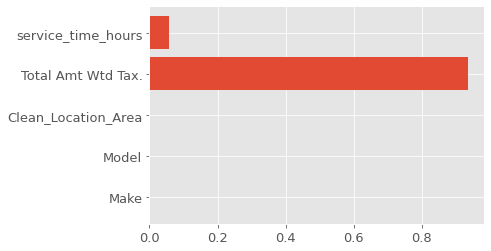

In [26]:
plt.barh(list(X),list(dt.feature_importances_))
plt.show()

In [27]:
### Cross Validation Score
dt_cv_score=cross_val_score(estimator=dt,X=X,y=y,cv=5)
print(dt_cv_score.mean())

0.8329748675129715


In [28]:
### Random Forest Classifier

In [29]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=8,random_state=0)
rfc.fit(X_train,y_train)
y_pred_rfc=rfc.predict(X_test)
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      4875
           1       0.87      1.00      0.93      9870
           2       0.71      0.69      0.70      4779

    accuracy                           0.84     19524
   macro avg       0.84      0.79      0.81     19524
weighted avg       0.85      0.84      0.84     19524



In [30]:
accuracy_score(y_test,y_pred_rfc)

0.8434746978078262

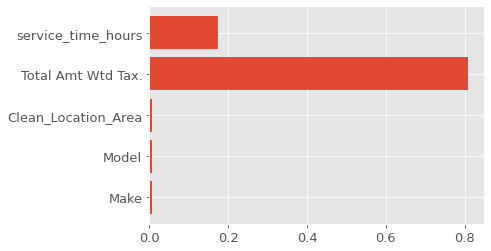

In [31]:
plt.barh(list(X),list(rfc.feature_importances_))
plt.show()

In [32]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [33]:
score.mean()

0.8072360717364054

In [34]:
### XgBoost Classifier

In [35]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)
accuracy_score(y_test,y_pred_xgb)

0.8598647818070068

In [36]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      4875
           1       0.90      0.98      0.94      9870
           2       0.73      0.73      0.73      4779

    accuracy                           0.86     19524
   macro avg       0.85      0.82      0.83     19524
weighted avg       0.86      0.86      0.86     19524



In [37]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)

In [38]:
scores_xgb.mean()

0.7741060195891656

# LTV Regression

In [39]:
df=invoice 

In [40]:
#For Customer Life time value prediction we need data only of 2015 hence Subset the data
cltv_df=df[['Customer No.','Cust Type','Invoice No','Make','Model','Total Amt Wtd Tax.','Clean_District','Year']]

#Subsetting the data
cltv_df=cltv_df[cltv_df['Year']==2015]
cltv_df.head()

,Customer No.,Cust Type,Invoice No,Make,Model,Total Amt Wtd Tax.,Clean_District,Year
0,67849,Retail,7005200002,GENERAL MOTORS,SPARK,4051,Maharashtra,2015
1,67849,Retail,7005200002,GENERAL MOTORS,SPARK,4051,Maharashtra,2015
2,67849,Retail,7005200002,GENERAL MOTORS,SPARK,4051,Maharashtra,2015
3,84419,Retail,7005200003,TATA,INDICA,1001,Maharashtra,2015
4,84419,Retail,7005200003,TATA,INDICA,1001,Maharashtra,2015


In [41]:
#Groupby of data
cltv_group=cltv_df.groupby(['Customer No.','Cust Type','Clean_District','Make','Model']).agg({'Invoice No':'nunique','Total Amt Wtd Tax.':'mean'}).reset_index()
#cltv_group.drop('year',1,inplace=True)
cltv_group.head()

,Customer No.,Cust Type,Clean_District,Make,Model,Invoice No,Total Amt Wtd Tax.
0,10000,Retail,Telangana,MARUTI,WAGONR,1,185.00
1,100000,Retail,Gujarat,HYUNDAI,ACCENT,1,6026.00
2,100001,Retail,Maharashtra,MAHINDRA,BOLERO,1,697.00
3,100001,Retail,Maharashtra,SKODA,SUPERB,1,1058.00
4,100001,Retail,Maharashtra,TOYOTA,INNOVA,1,2507.00


In [42]:
#finding customer value for year 2015
cltv_group['customer_value']=cltv_group['Invoice No']*cltv_group['Total Amt Wtd Tax.']
cltv_group.head()

,Customer No.,Cust Type,Clean_District,Make,Model,Invoice No,Total Amt Wtd Tax.,customer_value
0,10000,Retail,Telangana,MARUTI,WAGONR,1,185.00,185.00
1,100000,Retail,Gujarat,HYUNDAI,ACCENT,1,6026.00,6026.00
2,100001,Retail,Maharashtra,MAHINDRA,BOLERO,1,697.00,697.00
3,100001,Retail,Maharashtra,SKODA,SUPERB,1,1058.00,1058.00
4,100001,Retail,Maharashtra,TOYOTA,INNOVA,1,2507.00,2507.00


In [43]:
#Removing Customers with zero value
zero_group=cltv_group[cltv_group['customer_value']<=0].index
cltv_group.drop(zero_group,0,inplace=True)
cltv_group.head()

,Customer No.,Cust Type,Clean_District,Make,Model,Invoice No,Total Amt Wtd Tax.,customer_value
0,10000,Retail,Telangana,MARUTI,WAGONR,1,185.00,185.00
1,100000,Retail,Gujarat,HYUNDAI,ACCENT,1,6026.00,6026.00
2,100001,Retail,Maharashtra,MAHINDRA,BOLERO,1,697.00,697.00
3,100001,Retail,Maharashtra,SKODA,SUPERB,1,1058.00,1058.00
4,100001,Retail,Maharashtra,TOYOTA,INNOVA,1,2507.00,2507.00


In [44]:
#Creating Dataframe for Modelling 
model_df=cltv_group[['Customer No.','Cust Type','Clean_District','Make','Invoice No','Total Amt Wtd Tax.','customer_value']]
model_df.head()

,Customer No.,Cust Type,Clean_District,Make,Invoice No,Total Amt Wtd Tax.,customer_value
0,10000,Retail,Telangana,MARUTI,1,185.00,185.00
1,100000,Retail,Gujarat,HYUNDAI,1,6026.00,6026.00
2,100001,Retail,Maharashtra,MAHINDRA,1,697.00,697.00
3,100001,Retail,Maharashtra,SKODA,1,1058.00,1058.00
4,100001,Retail,Maharashtra,TOYOTA,1,2507.00,2507.00


In [45]:
#Renaming Columns
model_df.columns=['Cust_no.','Cust','State','Make','Count_invoice','Avg_revenue','customer_value']
model_df.head()

,Cust_no.,Cust,State,Make,Count_invoice,Avg_revenue,customer_value
0,10000,Retail,Telangana,MARUTI,1,185.00,185.00
1,100000,Retail,Gujarat,HYUNDAI,1,6026.00,6026.00
2,100001,Retail,Maharashtra,MAHINDRA,1,697.00,697.00
3,100001,Retail,Maharashtra,SKODA,1,1058.00,1058.00
4,100001,Retail,Maharashtra,TOYOTA,1,2507.00,2507.00


In [46]:
#Final dummyencoded dataframe
A=pd.get_dummies(data=model_df, columns=['Cust', 'State','Make'])

In [47]:
final_df=pd.DataFrame(A)
final_df.drop('Cust_no.',1,inplace=True)
final_df.head()

,Count_invoice,Avg_revenue,customer_value,Cust_Corporate others,Cust_Corporate- M&M,Cust_Fleets,Cust_Insurance,Cust_MFCWL,Cust_Retail,State_Andhra Pradesh,State_Bihar,State_Chandigarh,State_Chattisgarh,State_Dadra and Nagar Haveli and Daman and Diu,State_Delhi,State_Goa,State_Gujarat,State_Haryana,State_Himachal Pradesh,State_Jammu & Kashmir,State_Jharkhand,State_Karnataka,State_Kerala,State_Lakshadweep,State_Madhya Pradesh,State_Maharashtra,State_Pondicherry,State_Punjab,State_Rajasthan,State_Tamil Nadu,State_Telangana,State_Uttar Pradesh,State_Uttarakhand,State_West Bengal,Make_AUDI,Make_BMW,Make_DAEWOO,Make_FIAT,Make_FORCE,Make_FORD,Make_GENERAL MOTORS,Make_HINDUSTAN MOTORS,Make_HONDA,Make_HYUNDAI,Make_JEEP,Make_MAHINDRA,Make_MARUTI,Make_MERCEDES-BENZ,Make_MITSUBISHI MOTOR,Make_NISSAN,Make_PORSCHE,Make_PREMIER AUTOMOBILES,Make_RENAULT,Make_ROVER,Make_SKODA,Make_SONALIKA,Make_TATA,Make_TOYOTA,Make_VOLKSWAGEN,Make_VOLVO
0,1,185.00,185.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,6026.00,6026.00,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,697.00,697.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1058.00,1058.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,2507.00,2507.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
#Train Test Split 
X=final_df.drop('customer_value',1)
y=final_df['customer_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [49]:
from lazypredict.Supervised import LazyRegressor

In [50]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

 24%|███████████████████▋                                                               | 9/38 [00:04<00:19,  1.52it/s]

GaussianProcessRegressor model failed to execute



 37%|██████████████████████████████▏                                                   | 14/38 [00:10<00:26,  1.09s/it]

KernelRidge model failed to execute



100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [07:54<00:00, 12.50s/it]


,R-Squared,RMSE,Time Taken
Model,,,
ExtraTreesRegressor,0.98,3180.36,1.06
ExtraTreeRegressor,0.97,3679.84,0.12
BaggingRegressor,0.97,3761.94,1.39
RandomForestRegressor,0.96,3836.54,1.41
GradientBoostingRegressor,0.96,4125.34,1.79
KNeighborsRegressor,0.94,5114.60,1.78
LGBMRegressor,0.88,6936.91,0.80
HistGradientBoostingRegressor,0.88,6991.13,1.38
XGBRegressor,0.81,8786.86,2.53


In [51]:
## Decision Tree Regressor

In [52]:
#Implementing Decison Tree Regressor
from sklearn.tree import DecisionTreeRegressor

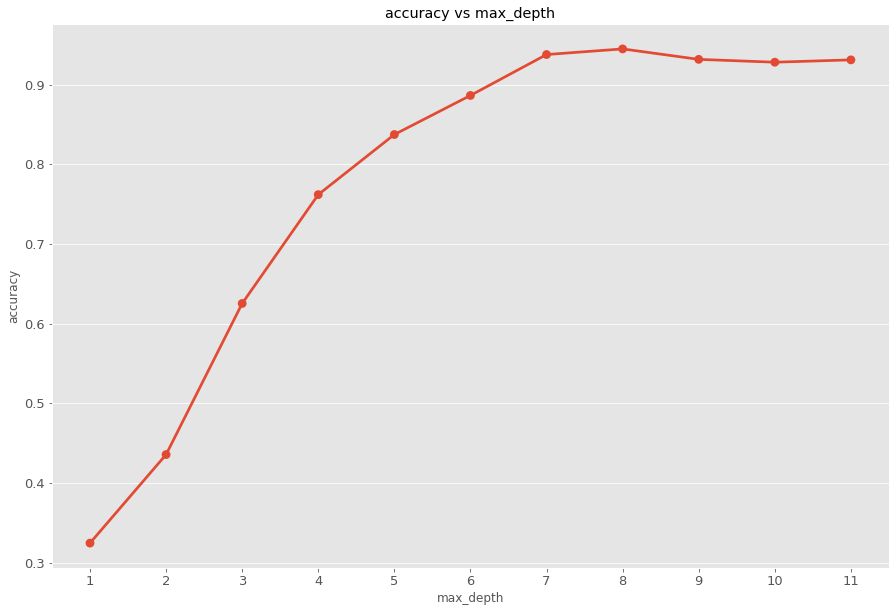

In [53]:
#Finding the Optimal Value For Max Depth
max_depth_range = list(range(1,12))
# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    reg = DecisionTreeRegressor(max_depth = depth, random_state = 18)
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    accuracy.append(score)
    
x=max_depth_range
y=accuracy

plt.figure(figsize=(15,10))
sns.pointplot(x,y)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('accuracy vs max_depth')
plt.show()

In [54]:
#Applying  Decision Tree Regressor
X=final_df.drop('customer_value',1)
y=final_df['customer_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)
dt_reg = DecisionTreeRegressor(max_depth=10, random_state = 18)
dt_reg.fit(X_train, y_train)
y_pred=dt_reg.predict(X_test)
#Evaluation metric
mse =mean_squared_error(y_test,y_pred)
print('mse score:',mse)
print('=='*100)
rmse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(rmse)
print('Rmse score:',rmse)

#accuracy score on train data
train_score=dt_reg.score(X_train,y_train)
print('train score:',train_score)
print('=='*100)

#accuracy score on test data
test_score=dt_reg.score(X_test,y_test)
print('test score:',test_score)
print('=='*100)


mse score: 34463796.89726805
Rmse score: 5870.587440560616
train score: 0.9983772333938794
test score: 0.9137064689501142


In [55]:
#Evaluation metric  R2 score
R2_Score=r2_score(y_test,y_pred)
print('R2 score:',R2_Score)
print('=='*100)

R2 score: 0.9137064689501142
